# The weather dataset
This tutorial uses a [weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
%load_ext tensorboard


In [2]:
import tensorflow as tf
import datetime

from lstm_timeseries import (data_proc, 
                             univariate_data, 
                             show_plot, 
                             baseline, 
                             multivariate_data,
                             single_step_model, 
                             TimeSeriesLSTM, 
                             plot_preds, 
                             train_val_tf)

import matplotlib.pyplot as plt
tf.random.set_seed(13)



In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [4]:
%%time
df = data_proc()

Wall time: 1.14 s


In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
TRAIN_SPLIT = 300000


# Part 1: Forecast a univariate time series

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

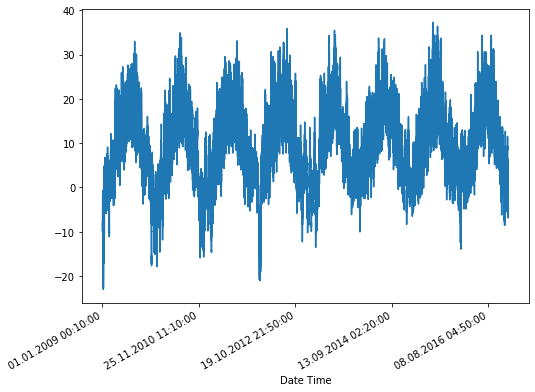

In [8]:
uni_data.plot(subplots=True);

In [9]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

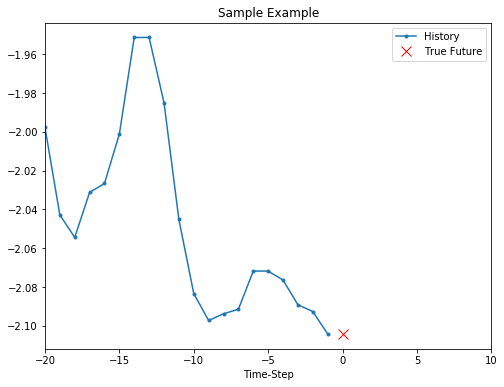

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

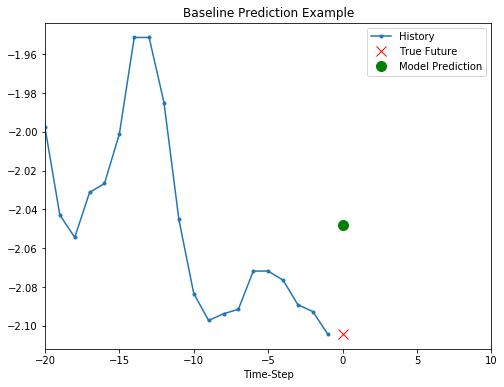

In [11]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

# Multivariate forecast with lstm

In [12]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


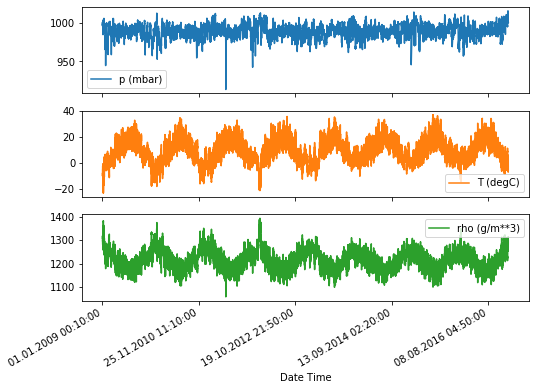

In [13]:
features.plot(subplots=True);

In [14]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean)/data_std

# Single step model
* multivariate features to predict next time step

In [15]:
# data for the last 5 days is used (720 observations) predict 12h ahead
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)



In [16]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [17]:
%%time
trained_model, single_step_history = single_step_model(x_train_single, 
                                                       y_train_single,
                                                       x_val_single, 
                                                       y_val_single,
                                                       epochs=2)



Train for 200 steps, validate for 50 steps
Epoch 1/2
200/200 [==============================] - ETA: 16:22 - loss: 1.13 - ETA: 2:17 - loss: 0.9236 - ETA: 1:12 - loss: 0.731 - ETA: 48s - loss: 0.617 - ETA: 36s - loss: 0.55 - ETA: 28s - loss: 0.52 - ETA: 23s - loss: 0.49 - ETA: 19s - loss: 0.47 - ETA: 16s - loss: 0.46 - ETA: 14s - loss: 0.45 - ETA: 12s - loss: 0.43 - ETA: 11s - loss: 0.42 - ETA: 9s - loss: 0.4175 - ETA: 8s - loss: 0.407 - ETA: 7s - loss: 0.398 - ETA: 7s - loss: 0.389 - ETA: 6s - loss: 0.382 - ETA: 5s - loss: 0.376 - ETA: 5s - loss: 0.370 - ETA: 4s - loss: 0.364 - ETA: 4s - loss: 0.360 - ETA: 3s - loss: 0.357 - ETA: 3s - loss: 0.353 - ETA: 2s - loss: 0.349 - ETA: 2s - loss: 0.345 - ETA: 2s - loss: 0.341 - ETA: 1s - loss: 0.338 - ETA: 1s - loss: 0.336 - ETA: 1s - loss: 0.334 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - 8s 38ms/step - loss: 0.3251 - val_loss: 0.2670
Epoch 2/2
200/200 [=============

# Plot first 3 predictions
Use validation data for predictions

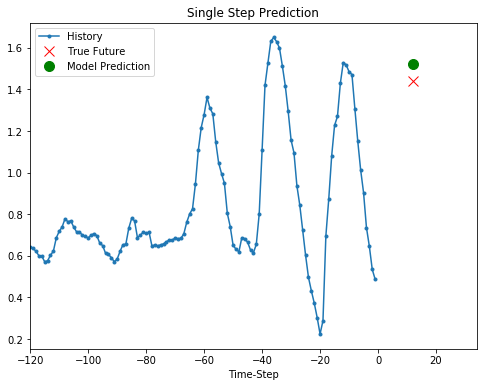

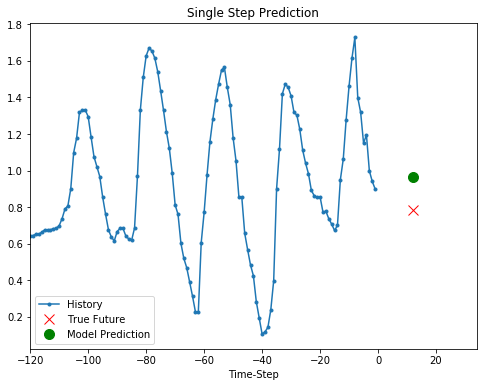

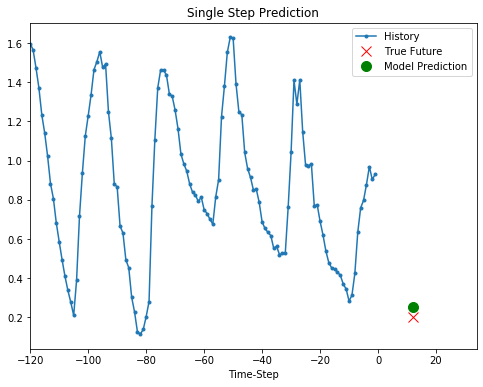

In [18]:

train_data_single, val_data_single = train_val_tf(x_train_single, y_train_single, x_val_single, y_val_single)
plot_preds(trained_model, val_data_single)



In [19]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

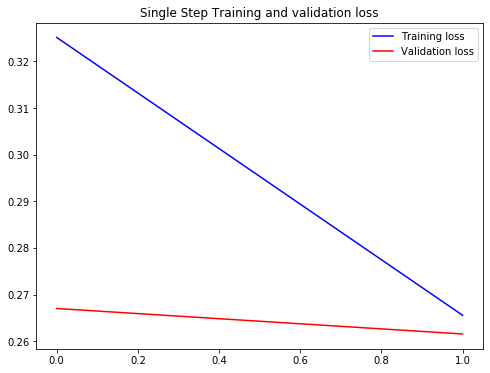

In [20]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Hyperparam search
### Hyperband
* Same data as in single step training above

In [21]:
%%time
from kerastuner.tuners import RandomSearch, Hyperband


hypermodel = TimeSeriesLSTM(num_outputs=1)
    
tuner = Hyperband(
    hypermodel,
    objective='mae',
    #max_trials=40,
    directory='hyperband',
    project_name='helloworld_hyperband', 
    max_epochs=2)



tuner.search(x_train_single,
             y_train_single, 
             epochs=2, 
             validation_data=(x_val_single, y_val_single))

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32224/299280 [==>...........................] - ETA: 4:34:33 - loss: 0.6486 - mae: 0.64 - ETA: 47:13 - loss: 0.6519 - mae: 0.6519 - ETA: 26:31 - loss: 0.6403 - mae: 0.64 - ETA: 18:46 - loss: 0.6012 - mae: 0.60 - ETA: 14:41 - loss: 0.5725 - mae: 0.57 - ETA: 12:12 - loss: 0.5402 - mae: 0.54 - ETA: 10:30 - loss: 0.5107 - mae: 0.51 - ETA: 9:17 - loss: 0.4905 - mae: 0.4905 - ETA: 8:21 - loss: 0.4740 - mae: 0.474 - ETA: 7:38 - loss: 0.4620 - mae: 0.462 - ETA: 7:02 - loss: 0.4534 - mae: 0.453 - ETA: 6:33 - loss: 0.4449 - mae: 0.444 - ETA: 6:10 - loss: 0.4380 - mae: 0.438 - ETA: 5:49 - loss: 0.4330 - mae: 0.433 - ETA: 5:32 - loss: 0.4295 - mae: 0.429 - ETA: 5:16 - loss: 0.4270 - mae: 0.427 - ETA: 5:03 - loss: 0.4230 - mae: 0.423 - ETA: 4:50 - loss: 0.4185 - mae: 0.418 - ETA: 4:40 - loss: 0.4130 - mae: 0.413 - ETA: 4:30 - loss: 0.4099 - mae: 0.409 - ETA: 4:21 - loss: 0.4076 - mae: 0.407 - ETA: 4:13 - loss: 0.4051 - mae: 0.405 - ETA: 4:06 - loss: 0.4031 - mae: 0.403 - ETA: 4:00 - loss: 0.3993 -

 64864/299280 [=====>........................] - ETA: 1:45 - loss: 0.2947 - mae: 0.294 - ETA: 1:45 - loss: 0.2945 - mae: 0.294 - ETA: 1:45 - loss: 0.2943 - mae: 0.294 - ETA: 1:45 - loss: 0.2942 - mae: 0.294 - ETA: 1:44 - loss: 0.2941 - mae: 0.294 - ETA: 1:44 - loss: 0.2939 - mae: 0.293 - ETA: 1:44 - loss: 0.2938 - mae: 0.293 - ETA: 1:44 - loss: 0.2937 - mae: 0.293 - ETA: 1:44 - loss: 0.2935 - mae: 0.293 - ETA: 1:44 - loss: 0.2933 - mae: 0.293 - ETA: 1:44 - loss: 0.2933 - mae: 0.293 - ETA: 1:44 - loss: 0.2931 - mae: 0.293 - ETA: 1:43 - loss: 0.2931 - mae: 0.293 - ETA: 1:43 - loss: 0.2930 - mae: 0.293 - ETA: 1:43 - loss: 0.2929 - mae: 0.292 - ETA: 1:43 - loss: 0.2929 - mae: 0.292 - ETA: 1:43 - loss: 0.2929 - mae: 0.292 - ETA: 1:43 - loss: 0.2927 - mae: 0.292 - ETA: 1:43 - loss: 0.2926 - mae: 0.292 - ETA: 1:43 - loss: 0.2926 - mae: 0.292 - ETA: 1:42 - loss: 0.2926 - mae: 0.292 - ETA: 1:42 - loss: 0.2924 - mae: 0.292 - ETA: 1:42 - loss: 0.2922 - mae: 0.292 - ETA: 1:42 - loss: 0.2920 - mae:

 97376/299280 [========>.....................] - ETA: 1:26 - loss: 0.2776 - mae: 0.277 - ETA: 1:26 - loss: 0.2775 - mae: 0.277 - ETA: 1:26 - loss: 0.2775 - mae: 0.277 - ETA: 1:26 - loss: 0.2775 - mae: 0.277 - ETA: 1:26 - loss: 0.2775 - mae: 0.277 - ETA: 1:26 - loss: 0.2774 - mae: 0.277 - ETA: 1:25 - loss: 0.2774 - mae: 0.277 - ETA: 1:25 - loss: 0.2773 - mae: 0.277 - ETA: 1:25 - loss: 0.2772 - mae: 0.277 - ETA: 1:25 - loss: 0.2771 - mae: 0.277 - ETA: 1:25 - loss: 0.2770 - mae: 0.277 - ETA: 1:25 - loss: 0.2770 - mae: 0.277 - ETA: 1:25 - loss: 0.2769 - mae: 0.276 - ETA: 1:25 - loss: 0.2768 - mae: 0.276 - ETA: 1:25 - loss: 0.2769 - mae: 0.276 - ETA: 1:25 - loss: 0.2768 - mae: 0.276 - ETA: 1:25 - loss: 0.2768 - mae: 0.276 - ETA: 1:25 - loss: 0.2768 - mae: 0.276 - ETA: 1:25 - loss: 0.2768 - mae: 0.276 - ETA: 1:25 - loss: 0.2767 - mae: 0.276 - ETA: 1:24 - loss: 0.2767 - mae: 0.276 - ETA: 1:24 - loss: 0.2766 - mae: 0.276 - ETA: 1:24 - loss: 0.2766 - mae: 0.276 - ETA: 1:24 - loss: 0.2765 - mae:

129984/299280 [============>.................] - ETA: 1:12 - loss: 0.2693 - mae: 0.269 - ETA: 1:12 - loss: 0.2693 - mae: 0.269 - ETA: 1:12 - loss: 0.2692 - mae: 0.269 - ETA: 1:12 - loss: 0.2692 - mae: 0.269 - ETA: 1:12 - loss: 0.2692 - mae: 0.269 - ETA: 1:12 - loss: 0.2691 - mae: 0.269 - ETA: 1:12 - loss: 0.2691 - mae: 0.269 - ETA: 1:12 - loss: 0.2691 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2689 - mae: 0.268 - ETA: 1:11 - loss: 0.2689 - mae: 0.268 - ETA: 1:11 - loss: 0.2689 - mae: 0.268 - ETA: 1:11 - loss: 0.2688 - mae: 0.268 - ETA: 1:11 - loss: 0.2688 - mae: 0.268 - ETA: 1:11 - loss: 0.2688 - mae: 0.268 - ETA: 1:11 - loss: 0.2688 - mae: 0.268 - ETA: 1:11 - loss: 0.2687 - mae: 0.268 - ETA: 1:11 - loss: 0.2688 - mae: 0.268 - ETA: 1:11 - loss: 0.2688 - mae: 0.268 - ETA: 1:11 - loss: 0.2687 - mae: 0.268 - ETA: 1:11 - loss: 0.2687 - mae: 0.268 - ETA: 1:11 - loss: 0.2686 - mae:

164320/299280 [===============>..............] - ETA: 1:00 - loss: 0.2651 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 1:00 - loss: 0.2651 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 59s - loss: 0.2650 - mae: 0.265 - ETA: 59s - loss: 0.2650 - mae: 0.26 - ETA: 59s - loss: 0.2650 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2648 - mae: 0.26 - ETA: 59s - loss: 0.2648 - mae: 0.26 - ETA: 59s - loss: 0.2648 - mae: 0.26 - ETA: 59s - loss: 0.2648 - mae: 0.26 - ETA: 59s - loss: 0.2648 - mae: 0.26 - ETA: 59s - loss: 0.2647 - mae: 0.26 - ETA: 59s - loss: 0.2647 - mae: 0.26 - ETA: 59s - loss: 0.2647 - mae: 0.26 - ETA: 59s - loss: 0.2647 - mae: 0.26 - ETA: 59s - loss: 0.2647 - mae: 0.26 - ETA: 58s - loss: 0.2647 - mae: 0.26 - ETA: 58s - loss: 0.2647 - mae: 0.26 - ETA: 58s - loss: 0.2647 - mae: 0.26 - ETA: 58s - loss: 0.2646 - ma

198656/299280 [==================>...........] - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - ETA: 46s - loss: 0.2611 - mae: 0.26 - E

233056/299280 [======================>.......] - ETA: 35s - loss: 0.2589 - mae: 0.25 - ETA: 35s - loss: 0.2589 - mae: 0.25 - ETA: 35s - loss: 0.2589 - mae: 0.25 - ETA: 35s - loss: 0.2589 - mae: 0.25 - ETA: 35s - loss: 0.2589 - mae: 0.25 - ETA: 35s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2589 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 34s - loss: 0.2588 - mae: 0.25 - ETA: 33s - loss: 0.2588 - mae: 0.25 - ETA: 33s - loss: 0.2588 - mae: 0.25 - E

267456/299280 [=========================>....] - ETA: 23s - loss: 0.2567 - mae: 0.25 - ETA: 23s - loss: 0.2567 - mae: 0.25 - ETA: 23s - loss: 0.2567 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2567 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2566 - mae: 0.25 - ETA: 22s - loss: 0.2565 - mae: 0.25 - ETA: 22s - loss: 0.2565 - mae: 0.25 - ETA: 21s - loss: 0.2565 - mae: 0.25 - ETA: 21s - loss: 0.2565 - mae: 0.25 - ETA: 21s - loss: 0.2565 - mae: 0.25 - ETA: 21s - loss: 0.2565 - mae: 0.25 - ETA: 21s - loss: 0.2565 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2552 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2552 - mae: 0.25 - ETA: 10s - loss: 0.2552 - mae: 0.25 - ETA: 10s - loss: 0.2552 - mae: 0.25 - ETA: 10s - loss: 0.2552 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 10s - loss: 0.2551 - mae: 0.25 - ETA: 9s - loss: 0.2551 - mae: 0.2551 - ETA: 9s - loss: 0.2551 - mae: 0.255 - ETA: 9s - loss: 0.2551 - mae: 0.255 - ETA: 9s - loss: 0.2551 - mae: 0.255 - ETA: 9s - loss: 0.2551 - mae: 0.255 - ETA: 9s - loss: 0.2551 - mae: 0.255 - 

 32480/299280 [==>...........................] - ETA: 2:19 - loss: 0.2745 - mae: 0.274 - ETA: 1:56 - loss: 0.2386 - mae: 0.238 - ETA: 1:56 - loss: 0.2408 - mae: 0.240 - ETA: 1:55 - loss: 0.2282 - mae: 0.228 - ETA: 1:54 - loss: 0.2376 - mae: 0.237 - ETA: 1:53 - loss: 0.2429 - mae: 0.242 - ETA: 1:52 - loss: 0.2428 - mae: 0.242 - ETA: 1:50 - loss: 0.2433 - mae: 0.243 - ETA: 1:50 - loss: 0.2390 - mae: 0.239 - ETA: 1:49 - loss: 0.2415 - mae: 0.241 - ETA: 1:48 - loss: 0.2426 - mae: 0.242 - ETA: 1:48 - loss: 0.2409 - mae: 0.240 - ETA: 1:47 - loss: 0.2409 - mae: 0.240 - ETA: 1:47 - loss: 0.2386 - mae: 0.238 - ETA: 1:47 - loss: 0.2385 - mae: 0.238 - ETA: 1:47 - loss: 0.2397 - mae: 0.239 - ETA: 1:46 - loss: 0.2397 - mae: 0.239 - ETA: 1:46 - loss: 0.2392 - mae: 0.239 - ETA: 1:47 - loss: 0.2394 - mae: 0.239 - ETA: 1:46 - loss: 0.2395 - mae: 0.239 - ETA: 1:46 - loss: 0.2393 - mae: 0.239 - ETA: 1:46 - loss: 0.2392 - mae: 0.239 - ETA: 1:45 - loss: 0.2387 - mae: 0.238 - ETA: 1:45 - loss: 0.2390 - mae:

 65088/299280 [=====>........................] - ETA: 1:32 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2420 - mae: 0.242 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2417 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2418 - mae: 0.241 - ETA: 1:31 - loss: 0.2417 - mae: 0.241 - ETA: 1:30 - loss: 0.2417 - mae: 0.241 - ETA: 1:30 - loss: 0.2417 - mae: 0.241 - ETA: 1:30 - loss: 0.2417 - mae: 0.241 - ETA: 1:30 - loss: 0.2418 - mae:

 97728/299280 [========>.....................] - ETA: 1:20 - loss: 0.2419 - mae: 0.241 - ETA: 1:20 - loss: 0.2418 - mae: 0.241 - ETA: 1:20 - loss: 0.2418 - mae: 0.241 - ETA: 1:20 - loss: 0.2418 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2417 - mae: 0.241 - ETA: 1:20 - loss: 0.2418 - mae: 0.241 - ETA: 1:20 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2418 - mae: 0.241 - ETA: 1:19 - loss: 0.2419 - mae: 0.241 - ETA: 1:19 - loss: 0.2419 - mae: 0.241 - ETA: 1:19 - loss: 0.2419 - mae:

130560/299280 [============>.................] - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2415 - mae: 0.241 - ETA: 1:09 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2415 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2414 - mae: 0.241 - ETA: 1:08 - loss: 0.2415 - mae: 0.241 - ETA: 1:08 - loss: 0.2415 - mae: 0.241 - ETA: 1:08 - loss: 0.2415 - mae: 0.241 - ETA: 1:08 - loss: 0.2415 - mae: 0.241 - ETA: 1:08 - loss: 0.2415 - mae:

164960/299280 [===============>..............] - ETA: 58s - loss: 0.2406 - mae: 0.24 - ETA: 58s - loss: 0.2406 - mae: 0.24 - ETA: 58s - loss: 0.2406 - mae: 0.24 - ETA: 58s - loss: 0.2406 - mae: 0.24 - ETA: 58s - loss: 0.2406 - mae: 0.24 - ETA: 57s - loss: 0.2406 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 57s - loss: 0.2405 - mae: 0.24 - ETA: 56s - loss: 0.2404 - mae: 0.24 - ETA: 56s - loss: 0.2404 - mae: 0.24 - E

199360/299280 [==================>...........] - ETA: 46s - loss: 0.2402 - mae: 0.24 - ETA: 46s - loss: 0.2402 - mae: 0.24 - ETA: 46s - loss: 0.2402 - mae: 0.24 - ETA: 46s - loss: 0.2402 - mae: 0.24 - ETA: 46s - loss: 0.2402 - mae: 0.24 - ETA: 46s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 44s - loss: 0.2402 - mae: 0.24 - E

233664/299280 [======================>.......] - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 34s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2396 - mae: 0.23 - ETA: 33s - loss: 0.2395 - mae: 0.23 - ETA: 33s - loss: 0.2395 - mae: 0.23 - ETA: 33s - loss: 0.2395 - mae: 0.23 - ETA: 33s - loss: 0.2395 - mae: 0.23 - ETA: 33s - loss: 0.2395 - mae: 0.23 - E

268064/299280 [=========================>....] - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 22s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - ETA: 21s - loss: 0.2393 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 10s - loss: 0.2388 - mae: 0.23 - ETA: 9s - loss: 0.2388 - mae: 0.2388 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - ETA: 9s - loss: 0.2388 - mae: 0.238 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38656/299280 [==>...........................] - ETA: 4:14:15 - loss: 0.7666 - mae: 0.76 - ETA: 37:29 - loss: 0.8356 - mae: 0.8356 - ETA: 20:49 - loss: 0.8222 - mae: 0.82 - ETA: 14:39 - loss: 0.7963 - mae: 0.79 - ETA: 11:27 - loss: 0.7635 - mae: 0.76 - ETA: 9:29 - loss: 0.7412 - mae: 0.7412 - ETA: 8:10 - loss: 0.7172 - mae: 0.717 - ETA: 7:13 - loss: 0.6961 - mae: 0.696 - ETA: 6:30 - loss: 0.6773 - mae: 0.677 - ETA: 5:56 - loss: 0.6560 - mae: 0.656 - ETA: 5:29 - loss: 0.6396 - mae: 0.639 - ETA: 5:07 - loss: 0.6249 - mae: 0.624 - ETA: 4:48 - loss: 0.6110 - mae: 0.611 - ETA: 4:32 - loss: 0.5990 - mae: 0.599 - ETA: 4:19 - loss: 0.5852 - mae: 0.585 - ETA: 4:07 - loss: 0.5708 - mae: 0.570 - ETA: 3:57 - loss: 0.5619 - mae: 0.561 - ETA: 3:48 - loss: 0.5539 - mae: 0.553 - ETA: 3:40 - loss: 0.5465 - mae: 0.546 - ETA: 3:32 - loss: 0.5387 - mae: 0.538 - ETA: 3:26 - loss: 0.5324 - mae: 0.532 - ETA: 3:20 - loss: 0.5246 - mae: 0.524 - ETA: 3:14 - loss: 0.5183 - mae: 0.518 - ETA: 3:09 - loss: 0.5136 -

 77824/299280 [======>.......................] - ETA: 1:22 - loss: 0.3197 - mae: 0.319 - ETA: 1:22 - loss: 0.3194 - mae: 0.319 - ETA: 1:22 - loss: 0.3192 - mae: 0.319 - ETA: 1:22 - loss: 0.3189 - mae: 0.318 - ETA: 1:22 - loss: 0.3186 - mae: 0.318 - ETA: 1:22 - loss: 0.3184 - mae: 0.318 - ETA: 1:22 - loss: 0.3181 - mae: 0.318 - ETA: 1:21 - loss: 0.3179 - mae: 0.317 - ETA: 1:21 - loss: 0.3176 - mae: 0.317 - ETA: 1:21 - loss: 0.3173 - mae: 0.317 - ETA: 1:21 - loss: 0.3171 - mae: 0.317 - ETA: 1:21 - loss: 0.3168 - mae: 0.316 - ETA: 1:21 - loss: 0.3166 - mae: 0.316 - ETA: 1:21 - loss: 0.3165 - mae: 0.316 - ETA: 1:21 - loss: 0.3162 - mae: 0.316 - ETA: 1:21 - loss: 0.3160 - mae: 0.316 - ETA: 1:20 - loss: 0.3158 - mae: 0.315 - ETA: 1:20 - loss: 0.3156 - mae: 0.315 - ETA: 1:20 - loss: 0.3155 - mae: 0.315 - ETA: 1:20 - loss: 0.3152 - mae: 0.315 - ETA: 1:20 - loss: 0.3148 - mae: 0.314 - ETA: 1:20 - loss: 0.3146 - mae: 0.314 - ETA: 1:20 - loss: 0.3142 - mae: 0.314 - ETA: 1:20 - loss: 0.3141 - mae:

118144/299280 [==========>...................] - ETA: 1:05 - loss: 0.2910 - mae: 0.291 - ETA: 1:05 - loss: 0.2908 - mae: 0.290 - ETA: 1:05 - loss: 0.2908 - mae: 0.290 - ETA: 1:05 - loss: 0.2906 - mae: 0.290 - ETA: 1:05 - loss: 0.2905 - mae: 0.290 - ETA: 1:05 - loss: 0.2904 - mae: 0.290 - ETA: 1:05 - loss: 0.2903 - mae: 0.290 - ETA: 1:05 - loss: 0.2903 - mae: 0.290 - ETA: 1:05 - loss: 0.2903 - mae: 0.290 - ETA: 1:04 - loss: 0.2902 - mae: 0.290 - ETA: 1:04 - loss: 0.2901 - mae: 0.290 - ETA: 1:04 - loss: 0.2901 - mae: 0.290 - ETA: 1:04 - loss: 0.2899 - mae: 0.289 - ETA: 1:04 - loss: 0.2899 - mae: 0.289 - ETA: 1:04 - loss: 0.2898 - mae: 0.289 - ETA: 1:04 - loss: 0.2897 - mae: 0.289 - ETA: 1:04 - loss: 0.2896 - mae: 0.289 - ETA: 1:04 - loss: 0.2895 - mae: 0.289 - ETA: 1:04 - loss: 0.2894 - mae: 0.289 - ETA: 1:04 - loss: 0.2893 - mae: 0.289 - ETA: 1:04 - loss: 0.2892 - mae: 0.289 - ETA: 1:04 - loss: 0.2892 - mae: 0.289 - ETA: 1:04 - loss: 0.2890 - mae: 0.289 - ETA: 1:04 - loss: 0.2890 - mae:

159456/299280 [==============>...............] - ETA: 52s - loss: 0.2795 - mae: 0.27 - ETA: 52s - loss: 0.2795 - mae: 0.27 - ETA: 52s - loss: 0.2795 - mae: 0.27 - ETA: 52s - loss: 0.2795 - mae: 0.27 - ETA: 52s - loss: 0.2794 - mae: 0.27 - ETA: 52s - loss: 0.2794 - mae: 0.27 - ETA: 52s - loss: 0.2794 - mae: 0.27 - ETA: 51s - loss: 0.2793 - mae: 0.27 - ETA: 51s - loss: 0.2793 - mae: 0.27 - ETA: 51s - loss: 0.2792 - mae: 0.27 - ETA: 51s - loss: 0.2792 - mae: 0.27 - ETA: 51s - loss: 0.2791 - mae: 0.27 - ETA: 51s - loss: 0.2791 - mae: 0.27 - ETA: 51s - loss: 0.2790 - mae: 0.27 - ETA: 51s - loss: 0.2789 - mae: 0.27 - ETA: 51s - loss: 0.2789 - mae: 0.27 - ETA: 51s - loss: 0.2789 - mae: 0.27 - ETA: 51s - loss: 0.2789 - mae: 0.27 - ETA: 51s - loss: 0.2788 - mae: 0.27 - ETA: 51s - loss: 0.2788 - mae: 0.27 - ETA: 51s - loss: 0.2788 - mae: 0.27 - ETA: 51s - loss: 0.2788 - mae: 0.27 - ETA: 51s - loss: 0.2787 - mae: 0.27 - ETA: 50s - loss: 0.2787 - mae: 0.27 - ETA: 50s - loss: 0.2787 - mae: 0.27 - E

199968/299280 [===================>..........] - ETA: 39s - loss: 0.2726 - mae: 0.27 - ETA: 39s - loss: 0.2726 - mae: 0.27 - ETA: 39s - loss: 0.2726 - mae: 0.27 - ETA: 39s - loss: 0.2726 - mae: 0.27 - ETA: 39s - loss: 0.2726 - mae: 0.27 - ETA: 39s - loss: 0.2725 - mae: 0.27 - ETA: 39s - loss: 0.2725 - mae: 0.27 - ETA: 39s - loss: 0.2725 - mae: 0.27 - ETA: 39s - loss: 0.2725 - mae: 0.27 - ETA: 39s - loss: 0.2725 - mae: 0.27 - ETA: 39s - loss: 0.2725 - mae: 0.27 - ETA: 39s - loss: 0.2724 - mae: 0.27 - ETA: 39s - loss: 0.2724 - mae: 0.27 - ETA: 39s - loss: 0.2724 - mae: 0.27 - ETA: 39s - loss: 0.2724 - mae: 0.27 - ETA: 39s - loss: 0.2723 - mae: 0.27 - ETA: 38s - loss: 0.2723 - mae: 0.27 - ETA: 38s - loss: 0.2723 - mae: 0.27 - ETA: 38s - loss: 0.2723 - mae: 0.27 - ETA: 38s - loss: 0.2722 - mae: 0.27 - ETA: 38s - loss: 0.2722 - mae: 0.27 - ETA: 38s - loss: 0.2722 - mae: 0.27 - ETA: 38s - loss: 0.2721 - mae: 0.27 - ETA: 38s - loss: 0.2721 - mae: 0.27 - ETA: 38s - loss: 0.2721 - mae: 0.27 - E

241248/299280 [=======================>......] - ETA: 28s - loss: 0.2686 - mae: 0.26 - ETA: 28s - loss: 0.2686 - mae: 0.26 - ETA: 28s - loss: 0.2686 - mae: 0.26 - ETA: 28s - loss: 0.2686 - mae: 0.26 - ETA: 28s - loss: 0.2686 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2685 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2684 - mae: 0.26 - ETA: 27s - loss: 0.2683 - mae: 0.26 - ETA: 27s - loss: 0.2683 - mae: 0.26 - ETA: 26s - loss: 0.2683 - mae: 0.26 - ETA: 26s - loss: 0.2683 - mae: 0.26 - E

282656/299280 [===========================>..] - ETA: 16s - loss: 0.2651 - mae: 0.26 - ETA: 16s - loss: 0.2651 - mae: 0.26 - ETA: 16s - loss: 0.2651 - mae: 0.26 - ETA: 16s - loss: 0.2651 - mae: 0.26 - ETA: 16s - loss: 0.2650 - mae: 0.26 - ETA: 16s - loss: 0.2650 - mae: 0.26 - ETA: 16s - loss: 0.2650 - mae: 0.26 - ETA: 16s - loss: 0.2650 - mae: 0.26 - ETA: 15s - loss: 0.2650 - mae: 0.26 - ETA: 15s - loss: 0.2650 - mae: 0.26 - ETA: 15s - loss: 0.2650 - mae: 0.26 - ETA: 15s - loss: 0.2650 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2649 - mae: 0.26 - ETA: 15s - loss: 0.2648 - mae: 0.26 - ETA: 15s - loss: 0.2648 - mae: 0.26 - ETA: 15s - loss: 0.2648 - mae: 0.26 - ETA: 15s - loss: 0.2648 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2628 - mae: 0.262 - ETA: 4s - loss: 0.2627 - mae: 0.262 - ETA: 4s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - ETA: 3s - loss: 0.2627 - mae: 0.262 - E

 39040/299280 [==>...........................] - ETA: 1:51 - loss: 0.2659 - mae: 0.265 - ETA: 1:27 - loss: 0.2474 - mae: 0.247 - ETA: 1:25 - loss: 0.2413 - mae: 0.241 - ETA: 1:25 - loss: 0.2422 - mae: 0.242 - ETA: 1:24 - loss: 0.2490 - mae: 0.249 - ETA: 1:24 - loss: 0.2471 - mae: 0.247 - ETA: 1:24 - loss: 0.2462 - mae: 0.246 - ETA: 1:23 - loss: 0.2465 - mae: 0.246 - ETA: 1:24 - loss: 0.2484 - mae: 0.248 - ETA: 1:24 - loss: 0.2452 - mae: 0.245 - ETA: 1:23 - loss: 0.2451 - mae: 0.245 - ETA: 1:23 - loss: 0.2433 - mae: 0.243 - ETA: 1:23 - loss: 0.2440 - mae: 0.244 - ETA: 1:23 - loss: 0.2445 - mae: 0.244 - ETA: 1:23 - loss: 0.2444 - mae: 0.244 - ETA: 1:22 - loss: 0.2450 - mae: 0.245 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2438 - mae: 0.243 - ETA: 1:22 - loss: 0.2432 - mae: 0.243 - ETA: 1:22 - loss: 0.2434 - mae: 0.243 - ETA: 1:22 - loss: 0.2434 - mae: 0.243 - ETA: 1:22 - loss: 0.2429 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2438 - mae:

 77504/299280 [======>.......................] - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2468 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2468 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2466 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2467 - mae: 0.246 - ETA: 1:11 - loss: 0.2466 - mae: 0.246 - ETA: 1:10 - loss: 0.2466 - mae: 0.246 - ETA: 1:10 - loss: 0.2467 - mae: 0.246 - ETA: 1:10 - loss: 0.2468 - mae: 0.246 - ETA: 1:10 - loss: 0.2467 - mae: 0.246 - ETA: 1:10 - loss: 0.2468 - mae: 0.246 - ETA: 1:10 - loss: 0.2469 - mae: 0.246 - ETA: 1:10 - loss: 0.2468 - mae: 0.246 - ETA: 1:10 - loss: 0.2468 - mae: 0.246 - ETA: 1:10 - loss: 0.2469 - mae: 0.246 - ETA: 1:10 - loss: 0.2470 - mae:

118368/299280 [==========>...................] - ETA: 1:01 - loss: 0.2462 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2462 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2462 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:01 - loss: 0.2463 - mae: 0.246 - ETA: 1:00 - loss: 0.2463 - mae: 0.246 - ETA: 1:00 - loss: 0.2464 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2466 - mae: 0.246 - ETA: 1:00 - loss: 0.2466 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae:

159712/299280 [===============>..............] - ETA: 50s - loss: 0.2456 - mae: 0.24 - ETA: 50s - loss: 0.2456 - mae: 0.24 - ETA: 49s - loss: 0.2456 - mae: 0.24 - ETA: 49s - loss: 0.2456 - mae: 0.24 - ETA: 49s - loss: 0.2456 - mae: 0.24 - ETA: 49s - loss: 0.2456 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2455 - mae: 0.24 - ETA: 49s - loss: 0.2454 - mae: 0.24 - ETA: 49s - loss: 0.2454 - mae: 0.24 - ETA: 49s - loss: 0.2453 - mae: 0.24 - ETA: 49s - loss: 0.2453 - mae: 0.24 - ETA: 48s - loss: 0.2453 - mae: 0.24 - ETA: 48s - loss: 0.2453 - mae: 0.24 - ETA: 48s - loss: 0.2453 - mae: 0.24 - ETA: 48s - loss: 0.2453 - mae: 0.24 - E

201024/299280 [===================>..........] - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 38s - loss: 0.2451 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2450 - mae: 0.24 - ETA: 37s - loss: 0.2451 - mae: 0.24 - ETA: 37s - loss: 0.2451 - mae: 0.24 - ETA: 37s - loss: 0.2451 - mae: 0.24 - E

242336/299280 [=======================>......] - ETA: 27s - loss: 0.2444 - mae: 0.24 - ETA: 27s - loss: 0.2445 - mae: 0.24 - ETA: 26s - loss: 0.2445 - mae: 0.24 - ETA: 26s - loss: 0.2445 - mae: 0.24 - ETA: 26s - loss: 0.2445 - mae: 0.24 - ETA: 26s - loss: 0.2445 - mae: 0.24 - ETA: 26s - loss: 0.2445 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 26s - loss: 0.2444 - mae: 0.24 - ETA: 25s - loss: 0.2444 - mae: 0.24 - ETA: 25s - loss: 0.2444 - mae: 0.24 - ETA: 25s - loss: 0.2444 - mae: 0.24 - ETA: 25s - loss: 0.2444 - mae: 0.24 - E

283488/299280 [===========================>..] - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2443 - mae: 0.24 - ETA: 15s - loss: 0.2442 - mae: 0.24 - ETA: 15s - loss: 0.2442 - mae: 0.24 - ETA: 15s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - ETA: 14s - loss: 0.2442 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 4s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - ETA: 3s - loss: 0.2438 - mae: 0.243 - E

INFO:tensorflow:Oracle triggered exit
Wall time: 7min 29s


In [22]:
models = tuner.get_best_models(num_models=1)

In [23]:
tuner.results_summary()

In [24]:
models

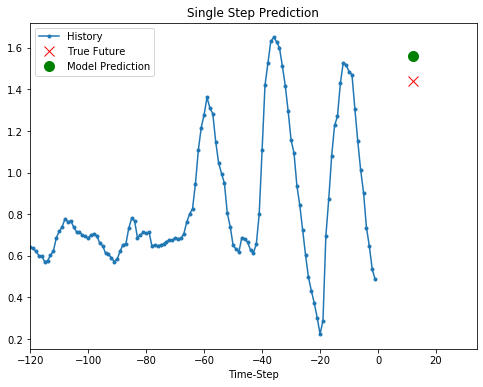

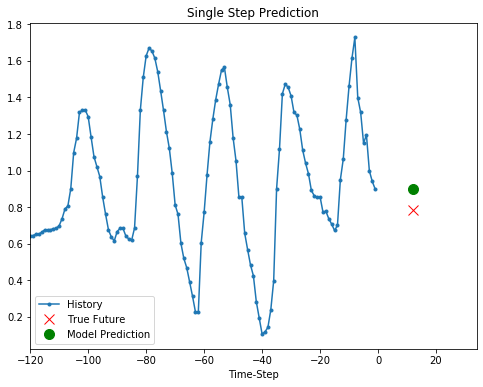

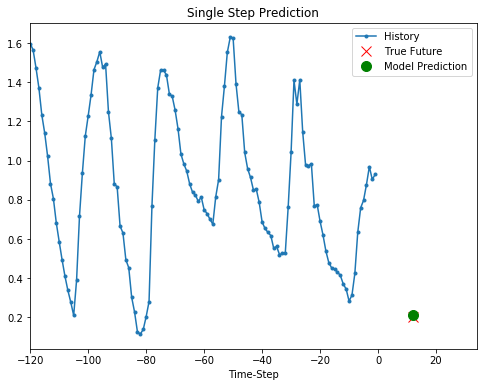

In [25]:
plot_preds(models[0], val_data_single)

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#loss, accuracy = best_model.evaluate(x_val_single, y_val_single)

#  Random Search

In [ ]:
%%time

randommodel = TimeSeriesLSTM(num_outputs=1)

random_tuner = RandomSearch(
    randommodel,
    objective='mae',
    max_trials=2,
    directory='random_search',
    project_name='helloworld_random')

random_tuner.search(x_train_single,
                    y_train_single, 
                    epochs=2, 
                    validation_data=(x_val_single, y_val_single), )

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38624/299280 [==>...........................] - ETA: 4:15:29 - loss: 0.5101 - mae: 0.51 - ETA: 37:45 - loss: 0.5968 - mae: 0.5968 - ETA: 21:00 - loss: 0.5256 - mae: 0.52 - ETA: 14:49 - loss: 0.4989 - mae: 0.49 - ETA: 11:35 - loss: 0.4736 - mae: 0.47 - ETA: 9:37 - loss: 0.4482 - mae: 0.4482 - ETA: 8:17 - loss: 0.4438 - mae: 0.443 - ETA: 7:19 - loss: 0.4327 - mae: 0.432 - ETA: 6:36 - loss: 0.4275 - mae: 0.427 - ETA: 6:02 - loss: 0.4193 - mae: 0.419 - ETA: 5:34 - loss: 0.4128 - mae: 0.412 - ETA: 5:12 - loss: 0.4059 - mae: 0.405 - ETA: 4:53 - loss: 0.4065 - mae: 0.406 - ETA: 4:37 - loss: 0.4023 - mae: 0.402 - ETA: 4:23 - loss: 0.3956 - mae: 0.395 - ETA: 4:11 - loss: 0.3893 - mae: 0.389 - ETA: 4:01 - loss: 0.3868 - mae: 0.386 - ETA: 3:52 - loss: 0.3839 - mae: 0.383 - ETA: 3:43 - loss: 0.3794 - mae: 0.379 - ETA: 3:36 - loss: 0.3762 - mae: 0.376 - ETA: 3:29 - loss: 0.3737 - mae: 0.373 - ETA: 3:23 - loss: 0.3718 - mae: 0.371 - ETA: 3:18 - loss: 0.3682 - mae: 0.368 - ETA: 3:13 - loss: 0.3677 -

 77792/299280 [======>.......................] - ETA: 1:25 - loss: 0.2963 - mae: 0.296 - ETA: 1:25 - loss: 0.2962 - mae: 0.296 - ETA: 1:25 - loss: 0.2961 - mae: 0.296 - ETA: 1:25 - loss: 0.2961 - mae: 0.296 - ETA: 1:25 - loss: 0.2958 - mae: 0.295 - ETA: 1:25 - loss: 0.2958 - mae: 0.295 - ETA: 1:25 - loss: 0.2957 - mae: 0.295 - ETA: 1:24 - loss: 0.2956 - mae: 0.295 - ETA: 1:24 - loss: 0.2955 - mae: 0.295 - ETA: 1:24 - loss: 0.2953 - mae: 0.295 - ETA: 1:24 - loss: 0.2953 - mae: 0.295 - ETA: 1:24 - loss: 0.2951 - mae: 0.295 - ETA: 1:24 - loss: 0.2951 - mae: 0.295 - ETA: 1:24 - loss: 0.2950 - mae: 0.295 - ETA: 1:24 - loss: 0.2948 - mae: 0.294 - ETA: 1:24 - loss: 0.2947 - mae: 0.294 - ETA: 1:23 - loss: 0.2946 - mae: 0.294 - ETA: 1:23 - loss: 0.2945 - mae: 0.294 - ETA: 1:23 - loss: 0.2944 - mae: 0.294 - ETA: 1:23 - loss: 0.2943 - mae: 0.294 - ETA: 1:23 - loss: 0.2941 - mae: 0.294 - ETA: 1:23 - loss: 0.2940 - mae: 0.294 - ETA: 1:23 - loss: 0.2938 - mae: 0.293 - ETA: 1:23 - loss: 0.2937 - mae:

117696/299280 [==========>...................] - ETA: 1:08 - loss: 0.2811 - mae: 0.281 - ETA: 1:08 - loss: 0.2810 - mae: 0.281 - ETA: 1:08 - loss: 0.2810 - mae: 0.281 - ETA: 1:07 - loss: 0.2809 - mae: 0.280 - ETA: 1:07 - loss: 0.2808 - mae: 0.280 - ETA: 1:07 - loss: 0.2807 - mae: 0.280 - ETA: 1:07 - loss: 0.2806 - mae: 0.280 - ETA: 1:07 - loss: 0.2806 - mae: 0.280 - ETA: 1:07 - loss: 0.2806 - mae: 0.280 - ETA: 1:07 - loss: 0.2806 - mae: 0.280 - ETA: 1:07 - loss: 0.2805 - mae: 0.280 - ETA: 1:07 - loss: 0.2805 - mae: 0.280 - ETA: 1:07 - loss: 0.2804 - mae: 0.280 - ETA: 1:07 - loss: 0.2804 - mae: 0.280 - ETA: 1:07 - loss: 0.2804 - mae: 0.280 - ETA: 1:07 - loss: 0.2803 - mae: 0.280 - ETA: 1:07 - loss: 0.2802 - mae: 0.280 - ETA: 1:06 - loss: 0.2801 - mae: 0.280 - ETA: 1:06 - loss: 0.2801 - mae: 0.280 - ETA: 1:06 - loss: 0.2800 - mae: 0.280 - ETA: 1:06 - loss: 0.2800 - mae: 0.280 - ETA: 1:06 - loss: 0.2800 - mae: 0.280 - ETA: 1:06 - loss: 0.2799 - mae: 0.279 - ETA: 1:06 - loss: 0.2799 - mae:

157728/299280 [==============>...............] - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2733 - mae: 0.27 - ETA: 54s - loss: 0.2733 - mae: 0.27 - ETA: 53s - loss: 0.2733 - mae: 0.27 - ETA: 53s - loss: 0.2732 - mae: 0.27 - ETA: 53s - loss: 0.2732 - mae: 0.27 - ETA: 53s - loss: 0.2732 - mae: 0.27 - ETA: 53s - loss: 0.2732 - mae: 0.27 - ETA: 53s - loss: 0.2731 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2729 - mae: 0.27 - ETA: 53s - loss: 0.2729 - mae: 0.27 - E

198688/299280 [==================>...........] - ETA: 42s - loss: 0.2685 - mae: 0.26 - ETA: 42s - loss: 0.2685 - mae: 0.26 - ETA: 42s - loss: 0.2685 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 40s - loss: 0.2682 - mae: 0.26 - ETA: 40s - loss: 0.2682 - mae: 0.26 - ETA: 40s - loss: 0.2682 - mae: 0.26 - E

239008/299280 [======================>.......] - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - E

279040/299280 [==========================>...] - ETA: 17s - loss: 0.2618 - mae: 0.26 - ETA: 17s - loss: 0.2617 - mae: 0.26 - ETA: 17s - loss: 0.2617 - mae: 0.26 - ETA: 17s - loss: 0.2617 - mae: 0.26 - ETA: 17s - loss: 0.2617 - mae: 0.26 - ETA: 17s - loss: 0.2617 - mae: 0.26 - ETA: 17s - loss: 0.2617 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - E

299104/299280 [============================>.] - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2593 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 4s - loss: 0.2592 - mae: 0.259 - ETA: 4s - loss: 0.2592 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - E

# Plot result of random search

In [ ]:
models = random_tuner.get_best_models(num_models=1)
print(random_tuner.results_summary())


In [ ]:
plot_preds(models[0], val_data_single)
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = random_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#loss, accuracy = best_model.evaluate(x_val_single, y_val_single)